# Week 10 
## การใช้งาน Push button switch บน ESP32 

## รายการอุปกรณ์

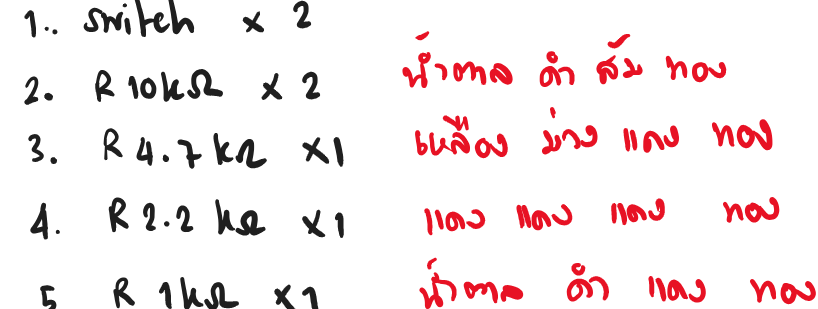
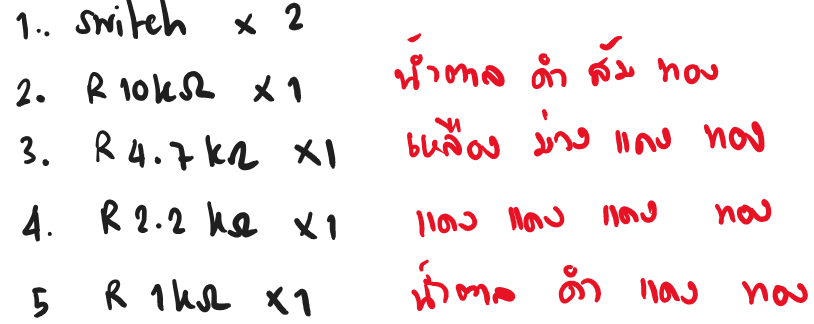

## ทฤษฎี Digital Input ของ ESP32

### 1. หลักการพื้นฐาน Digital Input
Digital Input คือการรับสัญญาณดิจิทัลจากภายนอก ซึ่งจะมีเพียง 2 สถานะ:
- **HIGH (1)**: แรงดันไฟฟ้าประมาณ 3.3V บน ESP32
- **LOW (0)**: แรงดันไฟฟ้าประมาณ 0V

### 2. GPIO Pins บน ESP32
ESP32 มี GPIO pins ที่สามารถใช้เป็น digital input ได้หลาย pins เช่น:
- GPIO 0, 2, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 32, 33

**ข้อระวัง**: บาง pins มีการใช้งานพิเศษ เช่น GPIO 0, 2 สำหรับ boot mode

### 3. Pull-up และ Pull-down Resistors

เมื่อใช้ push button กับ microcontroller จำเป็นต้องใช้ resistor เพื่อกำหนดสถานะของ pin เมื่อไม่มีการกด button:

#### Pull-up Resistor (แนะนำ)
- เชื่อมต่อระหว่าง GPIO pin กับ VCC (3.3V)
- เมื่อไม่กด button: pin อ่านค่า HIGH (1)
- เมื่อกด button: pin อ่านค่า LOW (0)

#### Pull-down Resistor
- เชื่อมต่อระหว่าง GPIO pin กับ GND (0V)
- เมื่อไม่กด button: pin อ่านค่า LOW (0)
- เมื่อกด button: pin อ่านค่า HIGH (1)

### 4. Internal Pull-up/Pull-down ของ ESP32
ESP32 มี internal pull-up และ pull-down resistors ประมาณ 45kΩ ที่สามารถ enable ได้ผ่าน software:
```cpp
pinMode(pin, INPUT_PULLUP);  // เปิด internal pull-up
pinMode(pin, INPUT_PULLDOWN); // เปิด internal pull-down (ESP32 เท่านั้น)
```

## การต่อวงจร Push Button กับ ESP32

### รูปแบบที่ 1: External Pull-up Resistor (แนะนำสำหรับการเรียนรู้)

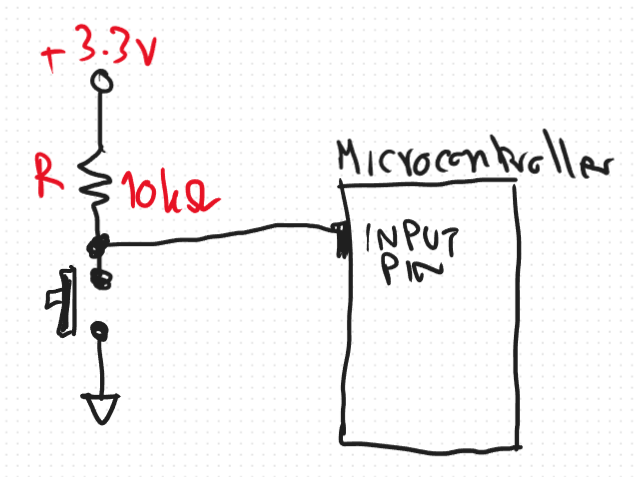


**อุปกรณ์ที่ใช้:**
- Push Button (Tact Switch) 1 ตัว
- ตัวต้านทาน 10kΩ 1 ตัว
- สายจัมเปอร์

**หลักการทำงาน:**
- เมื่อไม่กด button: กระแสไฟจาก 3.3V ผ่าน 10kΩ ไปยัง GPIO pin → อ่านค่า HIGH (1)
- เมื่อกด button: GPIO pin ต่อตรงกับ GND → อ่านค่า LOW (0)

### รูปแบบที่ 2: Internal Pull-up Resistor (ใช้งานง่าย)

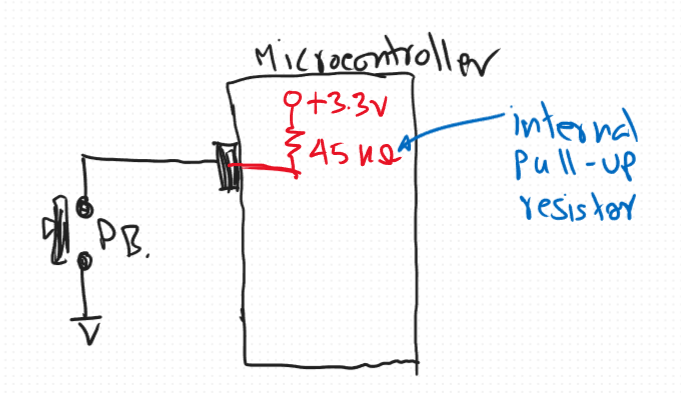

**อุปกรณ์ที่ใช้:**
- Push Button (Tact Switch) 1 ตัว
- สายจัมเปอร์ (ไม่ต้องใช้ตัวต้านทานภายนอก)

**ข้อดี:**
- ประหยัดชิ้นส่วน
- วงจรง่าย
- ได้ผลการทำงานเหมือนกัน

## การเขียนโปรแกรมด้วย ESP-IDF

ESP-IDF (Espressif IoT Development Framework) เป็น SDK อย่างเป็นทางการของ Espressif สำหรับ ESP32 ที่ให้ความสามารถและการควบคุมในระดับต่ำมากกว่า Arduino IDE

### ข้อดีของ ESP-IDF:
- ประสิทธิภาพสูงกว่า Arduino
- ควบคุมฮาร์ดแวร์ได้ละเอียดกว่า
- รองรับ FreeRTOS อย่างเต็มรูปแบบ
- Memory management ที่ดีกว่า

### ตัวอย่างที่ 1: Basic Digital Input ด้วย ESP-IDF

In [ ]:
// main.c - ตัวอย่างที่ 1: Basic Push Button ด้วย ESP-IDF
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/gpio.h"
#include "esp_log.h"

// กำหนด GPIO pins
#define BUTTON_PIN    GPIO_NUM_2    // Push button pin
#define LED_PIN       GPIO_NUM_23   // LED pin

// Tag สำหรับ logging
static const char *TAG = "BUTTON_EXAMPLE";

void app_main(void)
{
    // กำหนดค่า GPIO สำหรับ button (input with pull-up)
    gpio_config_t button_config = {
        .pin_bit_mask = (1ULL << BUTTON_PIN),
        .mode = GPIO_MODE_INPUT,
        .pull_up_en = GPIO_PULLUP_ENABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&button_config);
    
    // กำหนดค่า GPIO สำหรับ LED (output)
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    ESP_LOGI(TAG, "ESP32 Push Button Example - ESP-IDF");
    ESP_LOGI(TAG, "Button: GPIO%d, LED: GPIO%d", BUTTON_PIN, LED_PIN);
    
    int button_state;
    int last_state = 1;  // สถานะก่อนหน้า (pull-up = HIGH)
    
    while(1) {
        // อ่านค่าจาก button
        button_state = gpio_get_level(BUTTON_PIN);
        
        // ตรวจสอบการเปลี่ยนสถานะ
        if (button_state != last_state) {
            if (button_state == 0) {  // Button pressed (LOW)
                ESP_LOGI(TAG, "Button PRESSED!");
                gpio_set_level(LED_PIN, 1);  // เปิด LED
            } else {  // Button released (HIGH)
                ESP_LOGI(TAG, "Button RELEASED");
                gpio_set_level(LED_PIN, 0);  // ปิด LED
            }
            last_state = button_state;
        }
        
        // Delay 10ms
        vTaskDelay(pdMS_TO_TICKS(10));
    }
}

### ตัวอย่างที่ 2: Button Debouncing ด้วย ESP-IDF

In [ ]:
// main.c - ตัวอย่างที่ 2: Button Debouncing ด้วย ESP-IDF
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/gpio.h"
#include "esp_log.h"
#include "esp_timer.h"

#define BUTTON_PIN        GPIO_NUM_2
#define LED_PIN           GPIO_NUM_23
#define DEBOUNCE_TIME_MS  50

static const char *TAG = "BUTTON_DEBOUNCE";

// ตัวแปรสำหรับ debouncing
static int last_button_state = 1;
static int current_button_state = 1;
static int64_t last_debounce_time = 0;
static int press_count = 0;

void button_debounce_task(void *pvParameters)
{
    int reading;
    int64_t current_time;
    
    while(1) {
        reading = gpio_get_level(BUTTON_PIN);
        current_time = esp_timer_get_time() / 1000;  // Convert to milliseconds
        
        // ถ้าสถานะเปลี่ยน (อาจเป็น noise หรือการกดจริง)
        if (reading != last_button_state) {
            last_debounce_time = current_time;
        }
        
        // ถ้าผ่านเวลา debounce แล้ว
        if ((current_time - last_debounce_time) > DEBOUNCE_TIME_MS) {
            // ถ้าสถานะเปลี่ยนจริง
            if (reading != current_button_state) {
                current_button_state = reading;
                
                if (current_button_state == 0) {  // Button pressed
                    press_count++;
                    ESP_LOGI(TAG, "Button pressed! Count: %d", press_count);
                    
                    // Toggle LED
                    int led_state = gpio_get_level(LED_PIN);
                    gpio_set_level(LED_PIN, !led_state);
                } else {  // Button released
                    ESP_LOGI(TAG, "Button released");
                }
            }
        }
        
        last_button_state = reading;
        vTaskDelay(pdMS_TO_TICKS(10));  // Check every 10ms
    }
}

void app_main(void)
{
    // กำหนดค่า GPIO
    gpio_config_t button_config = {
        .pin_bit_mask = (1ULL << BUTTON_PIN),
        .mode = GPIO_MODE_INPUT,
        .pull_up_en = GPIO_PULLUP_ENABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&button_config);
    
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    // เริ่ม LED ในสถานะปิด
    gpio_set_level(LED_PIN, 0);
    
    ESP_LOGI(TAG, "Button Debouncing Example - ESP-IDF");
    ESP_LOGI(TAG, "Press count: %d", press_count);
    
    // สร้าง task สำหรับ button debouncing
    xTaskCreate(button_debounce_task, "button_task", 2048, NULL, 10, NULL);
}

### ตัวอย่างที่ 3: GPIO Interrupt สำหรับ Push Button

In [ ]:
// main.c - ตัวอย่างที่ 3: GPIO Interrupt สำหรับ Push Button
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "freertos/queue.h"
#include "driver/gpio.h"
#include "esp_log.h"

#define BUTTON_PIN    GPIO_NUM_2
#define LED_PIN       GPIO_NUM_23
#define ESP_INTR_FLAG_DEFAULT 0

static const char *TAG = "BUTTON_INTERRUPT";

// Queue สำหรับส่งข้อมูล interrupt
static QueueHandle_t gpio_evt_queue = NULL;

// ISR Handler (Interrupt Service Routine)
static void IRAM_ATTR gpio_isr_handler(void* arg)
{
    uint32_t gpio_num = (uint32_t) arg;
    xQueueSendFromISR(gpio_evt_queue, &gpio_num, NULL);
}

// Task สำหรับจัดการ GPIO events
static void gpio_task_example(void* arg)
{
    uint32_t io_num;
    int press_count = 0;
    
    for(;;) {
        if(xQueueReceive(gpio_evt_queue, &io_num, portMAX_DELAY)) {
            
            // Debouncing - รอสักครู่แล้วตรวจสอบสถานะอีกครั้ง
            vTaskDelay(pdMS_TO_TICKS(50));
            
            if (gpio_get_level(io_num) == 0) {  // ถ้ายังคงเป็น LOW (button ยังกดอยู่)
                press_count++;
                ESP_LOGI(TAG, "GPIO[%d] interrupt triggered! Press count: %d", io_num, press_count);
                
                // Toggle LED
                int led_state = gpio_get_level(LED_PIN);
                gpio_set_level(LED_PIN, !led_state);
            }
        }
    }
}

void app_main(void)
{
    // กำหนดค่า GPIO สำหรับ button
    gpio_config_t io_conf = {};
    io_conf.intr_type = GPIO_INTR_NEGEDGE;        // Interrupt เมื่อ falling edge (HIGH->LOW)
    io_conf.pin_bit_mask = (1ULL << BUTTON_PIN);
    io_conf.mode = GPIO_MODE_INPUT;
    io_conf.pull_up_en = GPIO_PULLUP_ENABLE;
    gpio_config(&io_conf);
    
    // กำหนดค่า GPIO สำหรับ LED
    io_conf.intr_type = GPIO_INTR_DISABLE;
    io_conf.pin_bit_mask = (1ULL << LED_PIN);
    io_conf.mode = GPIO_MODE_OUTPUT;
    io_conf.pull_up_en = GPIO_PULLUP_DISABLE;
    gpio_config(&io_conf);
    
    // เริ่ม LED ในสถานะปิด
    gpio_set_level(LED_PIN, 0);
    
    // สร้าง queue สำหรับ GPIO events
    gpio_evt_queue = xQueueCreate(10, sizeof(uint32_t));
    
    // สร้าง task สำหรับจัดการ GPIO
    xTaskCreate(gpio_task_example, "gpio_task_example", 2048, NULL, 10, NULL);
    
    // ติดตั้ง GPIO ISR service
    gpio_install_isr_service(ESP_INTR_FLAG_DEFAULT);
    
    // เพิ่ม ISR handler สำหรับ GPIO pin
    gpio_isr_handler_add(BUTTON_PIN, gpio_isr_handler, (void*) BUTTON_PIN);
    
    ESP_LOGI(TAG, "GPIO Interrupt Example - ESP-IDF");
    ESP_LOGI(TAG, "Button: GPIO%d (interrupt), LED: GPIO%d", BUTTON_PIN, LED_PIN);
    
    // Main task ไม่ต้องทำอะไร - interrupt จะจัดการทั้งหมด
    while(1) {
        vTaskDelay(pdMS_TO_TICKS(1000));
    }
}

### ตัวอย่างที่ 4: Dual Button Calculator ด้วย ESP-IDF

In [ ]:
// main.c - ตัวอย่างที่ 4: Dual Button Calculator ด้วย ESP-IDF
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "freertos/queue.h"
#include "driver/gpio.h"
#include "esp_log.h"
#include "esp_timer.h"

#define BUTTON_UP_PIN     GPIO_NUM_2    // Button เพิ่มค่า
#define BUTTON_DOWN_PIN   GPIO_NUM_4    // Button ลดค่า
#define LED_PIN           GPIO_NUM_23   // LED แสดงสถานะ
#define DEBOUNCE_TIME_MS  50
#define MIN_VALUE         -99
#define MAX_VALUE         99

static const char *TAG = "CALCULATOR";

// ตัวแปรสำหรับ calculator
static int counter = 0;

// ตัวแปรสำหรับ debouncing
typedef struct {
    int last_state;
    int current_state;
    int64_t last_debounce_time;
} button_state_t;

static button_state_t up_button = {1, 1, 0};
static button_state_t down_button = {1, 1, 0};

// ฟังก์ชันกระพริบ LED
void blink_led(int times)
{
    for (int i = 0; i < times; i++) {
        gpio_set_level(LED_PIN, 1);
        vTaskDelay(pdMS_TO_TICKS(100));
        gpio_set_level(LED_PIN, 0);
        vTaskDelay(pdMS_TO_TICKS(100));
    }
}

// ฟังก์ชันตรวจสอบ button debouncing
bool check_button_press(gpio_num_t pin, button_state_t *btn_state)
{
    int reading = gpio_get_level(pin);
    int64_t current_time = esp_timer_get_time() / 1000;  // Convert to ms
    bool button_pressed = false;
    
    // ถ้าสถานะเปลี่ยน
    if (reading != btn_state->last_state) {
        btn_state->last_debounce_time = current_time;
    }
    
    // ถ้าผ่านเวลา debounce แล้ว
    if ((current_time - btn_state->last_debounce_time) > DEBOUNCE_TIME_MS) {
        // ถ้าสถานะเปลี่ยนจริง
        if (reading != btn_state->current_state) {
            btn_state->current_state = reading;
            
            // ถ้าเป็นการกด button (HIGH -> LOW)
            if (btn_state->current_state == 0) {
                button_pressed = true;
            }
        }
    }
    
    btn_state->last_state = reading;
    return button_pressed;
}

// Task สำหรับ calculator
void calculator_task(void *pvParameters)
{
    ESP_LOGI(TAG, "=== ESP32 Simple Calculator (ESP-IDF) ===");
    ESP_LOGI(TAG, "Button UP (GPIO%d): +1", BUTTON_UP_PIN);
    ESP_LOGI(TAG, "Button DOWN (GPIO%d): -1", BUTTON_DOWN_PIN);
    ESP_LOGI(TAG, "Both buttons: Reset to 0");
    ESP_LOGI(TAG, "========================================");
    ESP_LOGI(TAG, "Current value: %d", counter);
    
    while(1) {
        bool up_pressed = check_button_press(BUTTON_UP_PIN, &up_button);
        bool down_pressed = check_button_press(BUTTON_DOWN_PIN, &down_button);
        
        if (up_pressed) {
            // ตรวจสอบว่า down button ถูกกดพร้อมกันหรือไม่
            if (gpio_get_level(BUTTON_DOWN_PIN) == 0) {
                // ทั้งสอง buttons ถูกกดพร้อมกัน - รีเซ็ต
                counter = 0;
                ESP_LOGI(TAG, "*** RESET ***");
                blink_led(3);
            } else {
                // เพิ่มค่า
                if (counter < MAX_VALUE) {
                    counter++;
                    ESP_LOGI(TAG, "UP pressed! ");
                } else {
                    ESP_LOGI(TAG, "MAX reached! ");
                }
            }
            ESP_LOGI(TAG, "Current value: %d", counter);
        }
        
        if (down_pressed && gpio_get_level(BUTTON_UP_PIN) == 1) {
            // ลดค่า (และไม่ได้กด UP button พร้อมกัน)
            if (counter > MIN_VALUE) {
                counter--;
                ESP_LOGI(TAG, "DOWN pressed! ");
            } else {
                ESP_LOGI(TAG, "MIN reached! ");
            }
            ESP_LOGI(TAG, "Current value: %d", counter);
        }
        
        vTaskDelay(pdMS_TO_TICKS(10));  // Check every 10ms
    }
}

void app_main(void)
{
    // กำหนดค่า GPIO สำหรับ buttons
    gpio_config_t button_config = {
        .pin_bit_mask = (1ULL << BUTTON_UP_PIN) | (1ULL << BUTTON_DOWN_PIN),
        .mode = GPIO_MODE_INPUT,
        .pull_up_en = GPIO_PULLUP_ENABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&button_config);
    
    // กำหนดค่า GPIO สำหรับ LED
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    // เริ่ม LED ในสถานะปิด
    gpio_set_level(LED_PIN, 0);
    
    // สร้าง task สำหรับ calculator
    xTaskCreate(calculator_task, "calculator_task", 4096, NULL, 10, NULL);
}

### ตัวอย่างที่ 5: LED Toggle ด้วย push button ใน ESP-IDF

In [ ]:
// main.c - ตัวอย่างที่ 5: LED Toggle ด้วย push button ใน ESP-IDF
// การสลับสถานะ LED ทุกครั้งที่กด button (Toggle Function)
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/gpio.h"
#include "esp_log.h"
#include "esp_timer.h"
#include <stdbool.h>

#define BUTTON_PIN        GPIO_NUM_2    // Push button pin
#define LED_PIN           GPIO_NUM_23   // LED pin
#define DEBOUNCE_TIME_MS  50           // Debounce time in milliseconds

static const char *TAG = "LED_TOGGLE";

// ตัวแปรสำหรับ LED toggle
static bool led_state = false;        // สถานะปัจจุบันของ LED
static int toggle_count = 0;          // จำนวนครั้งที่ toggle

// ตัวแปรสำหรับ button debouncing
static int last_button_state = 1;     // สถานะก่อนหน้า (pull-up = HIGH)
static int current_button_state = 1;  // สถานะปัจจุบัน
static int64_t last_debounce_time = 0; // เวลา debounce ล่าสุด

// ฟังก์ชัน Toggle LED
void toggle_led(void)
{
    led_state = !led_state;              // สลับสถานะ
    gpio_set_level(LED_PIN, led_state);  // ตั้งค่า GPIO ตามสถานะใหม่
    toggle_count++;                      // เพิ่มตัวนับ
    
    ESP_LOGI(TAG, "LED %s (Toggle count: %d)", 
             led_state ? "ON" : "OFF", toggle_count);
}

// Task สำหรับตรวจสอบ button และ toggle LED
void button_toggle_task(void *pvParameters)
{
    int reading;
    int64_t current_time;
    
    ESP_LOGI(TAG, "LED Toggle Example - ESP-IDF");
    ESP_LOGI(TAG, "Press button to toggle LED");
    ESP_LOGI(TAG, "Initial LED state: %s", led_state ? "ON" : "OFF");
    
    while(1) {
        reading = gpio_get_level(BUTTON_PIN);
        current_time = esp_timer_get_time() / 1000;  // Convert to milliseconds
        
        // ถ้าสถานะเปลี่ยนจากครั้งก่อน (อาจเป็น noise หรือการกดจริง)
        if (reading != last_button_state) {
            last_debounce_time = current_time;
        }
        
        // ถ้าผ่านเวลา debounce แล้ว
        if ((current_time - last_debounce_time) > DEBOUNCE_TIME_MS) {
            // ถ้าสถานะเปลี่ยนจริง
            if (reading != current_button_state) {
                current_button_state = reading;
                
                // ถ้าเป็นการกด button (เปลี่ยนจาก HIGH เป็น LOW)
                if (current_button_state == 0) {
                    ESP_LOGI(TAG, "Button pressed!");
                    toggle_led();  // Toggle LED
                } else {
                    ESP_LOGI(TAG, "Button released");
                }
            }
        }
        
        last_button_state = reading;
        vTaskDelay(pdMS_TO_TICKS(10));  // Check every 10ms
    }
}

void app_main(void)
{
    // กำหนดค่า GPIO สำหรับ button (input with pull-up)
    gpio_config_t button_config = {
        .pin_bit_mask = (1ULL << BUTTON_PIN),
        .mode = GPIO_MODE_INPUT,
        .pull_up_en = GPIO_PULLUP_ENABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&button_config);
    
    // กำหนดค่า GPIO สำหรับ LED (output)
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    // เริ่ม LED ในสถานะปิด
    gpio_set_level(LED_PIN, led_state);
    
    ESP_LOGI(TAG, "GPIO Configuration Complete");
    ESP_LOGI(TAG, "Button: GPIO%d, LED: GPIO%d", BUTTON_PIN, LED_PIN);
    
    // สร้าง task สำหรับ button toggle
    xTaskCreate(button_toggle_task, "button_toggle_task", 2048, NULL, 10, NULL);
}

### ตัวอย่างที่ 6: ใช้ push button 2 ตัว ควบคุม LED 4 ตัว

การสร้างเอฟเฟกต์ LED วิ่งซ้าย-ขวา:
- **Button 1 (GPIO2)**: LED วิ่งซ้าย (LED1→LED2→LED3→LED4)
- **Button 2 (GPIO4)**: LED วิ่งขวา (LED4→LED3→LED2→LED1)

In [ ]:
// main.c - ตัวอย่างที่ 6: Push Button 2 ตัว ควบคุม LED 4 ตัว (Running Left/Right)
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/gpio.h"
#include "esp_log.h"
#include "esp_timer.h"
#include <stdbool.h>

// กำหนด GPIO pins
#define BUTTON_LEFT_PIN   GPIO_NUM_2    // Button สำหรับ LED วิ่งซ้าย
#define BUTTON_RIGHT_PIN  GPIO_NUM_4    // Button สำหรับ LED วิ่งขวา

#define LED1_PIN          GPIO_NUM_19   // LED ตัวที่ 1 (ซ้ายสุด)
#define LED2_PIN          GPIO_NUM_21   // LED ตัวที่ 2
#define LED3_PIN          GPIO_NUM_22   // LED ตัวที่ 3
#define LED4_PIN          GPIO_NUM_23   // LED ตัวที่ 4 (ขวาสุด)

#define DEBOUNCE_TIME_MS  50           // Debounce time
#define LED_RUN_SPEED_MS  200          // ความเร็วการวิ่งของ LED

static const char *TAG = "LED_RUNNER";

// Array ของ LED pins เพื่อความสะดวกในการควบคุม
static const gpio_num_t led_pins[4] = {LED1_PIN, LED2_PIN, LED3_PIN, LED4_PIN};

// ตัวแปรสำหรับ LED running
static bool is_running_left = false;
static bool is_running_right = false;
static int current_led_index = 0;

// ตัวแปรสำหรับ button debouncing
typedef struct {
    int last_state;
    int current_state;
    int64_t last_debounce_time;
} button_state_t;

static button_state_t left_button = {1, 1, 0};
static button_state_t right_button = {1, 1, 0};

// ฟังก์ชันปิด LED ทั้งหมด
void turn_off_all_leds(void)
{
    for (int i = 0; i < 4; i++) {
        gpio_set_level(led_pins[i], 0);
    }
}

// ฟังก์ชันเปิด LED ตัวเดียว
void turn_on_single_led(int index)
{
    turn_off_all_leds();
    if (index >= 0 && index < 4) {
        gpio_set_level(led_pins[index], 1);
    }
}

// ฟังก์ชันตรวจสอบ button press พร้อม debouncing
bool check_button_press(gpio_num_t pin, button_state_t *btn_state)
{
    int reading = gpio_get_level(pin);
    int64_t current_time = esp_timer_get_time() / 1000;  // Convert to ms
    bool button_pressed = false;
    
    if (reading != btn_state->last_state) {
        btn_state->last_debounce_time = current_time;
    }
    
    if ((current_time - btn_state->last_debounce_time) > DEBOUNCE_TIME_MS) {
        if (reading != btn_state->current_state) {
            btn_state->current_state = reading;
            
            if (btn_state->current_state == 0) {  // Button pressed
                button_pressed = true;
            }
        }
    }
    
    btn_state->last_state = reading;
    return button_pressed;
}

// Task สำหรับ LED running effect
void led_running_task(void *pvParameters)
{
    int64_t last_led_update = 0;
    
    while(1) {
        int64_t current_time = esp_timer_get_time() / 1000;
        
        // อัปเดต LED เมื่อถึงเวลา
        if ((current_time - last_led_update) >= LED_RUN_SPEED_MS) {
            if (is_running_left) {
                current_led_index++;
                if (current_led_index >= 4) {
                    current_led_index = 0;  // วนกลับไปตัวแรก
                }
                turn_on_single_led(current_led_index);
                ESP_LOGI(TAG, "LED Running Left - LED%d ON", current_led_index + 1);
                
            } else if (is_running_right) {
                current_led_index--;
                if (current_led_index < 0) {
                    current_led_index = 3;  // วนกลับไปตัวสุดท้าย
                }
                turn_on_single_led(current_led_index);
                ESP_LOGI(TAG, "LED Running Right - LED%d ON", current_led_index + 1);
            }
            
            last_led_update = current_time;
        }
        
        vTaskDelay(pdMS_TO_TICKS(10));
    }
}

// Task สำหรับตรวจสอบ buttons
void button_check_task(void *pvParameters)
{
    ESP_LOGI(TAG, "=== LED Running Control ===");
    ESP_LOGI(TAG, "Button Left (GPIO%d): LED วิ่งซ้าย", BUTTON_LEFT_PIN);
    ESP_LOGI(TAG, "Button Right (GPIO%d): LED วิ่งขวา", BUTTON_RIGHT_PIN);
    ESP_LOGI(TAG, "LED Pins: GPIO%d, GPIO%d, GPIO%d, GPIO%d", 
             LED1_PIN, LED2_PIN, LED3_PIN, LED4_PIN);
    ESP_LOGI(TAG, "==========================");
    
    while(1) {
        bool left_pressed = check_button_press(BUTTON_LEFT_PIN, &left_button);
        bool right_pressed = check_button_press(BUTTON_RIGHT_PIN, &right_button);
        
        if (left_pressed) {
            ESP_LOGI(TAG, "Left Button Pressed - Starting LED Run Left");
            is_running_right = false;  // หยุดการวิ่งขวา
            is_running_left = true;    // เริ่มการวิ่งซ้าย
            current_led_index = 0;     // เริ่มจาก LED ตัวแรก
        }
        
        if (right_pressed) {
            ESP_LOGI(TAG, "Right Button Pressed - Starting LED Run Right");
            is_running_left = false;   // หยุดการวิ่งซ้าย
            is_running_right = true;   // เริ่มการวิ่งขวา
            current_led_index = 3;     // เริ่มจาก LED ตัวสุดท้าย
        }
        
        // หยุดการวิ่งถ้ากดทั้งสอง buttons พร้อมกัน
        if (gpio_get_level(BUTTON_LEFT_PIN) == 0 && gpio_get_level(BUTTON_RIGHT_PIN) == 0) {
            ESP_LOGI(TAG, "Both Buttons Pressed - Stop All LED Running");
            is_running_left = false;
            is_running_right = false;
            turn_off_all_leds();
            vTaskDelay(pdMS_TO_TICKS(500));  // หน่วงเวลาป้องกันการกดซ้ำ
        }
        
        vTaskDelay(pdMS_TO_TICKS(10));
    }
}

void app_main(void)
{
    // กำหนดค่า GPIO สำหรับ buttons
    gpio_config_t button_config = {
        .pin_bit_mask = (1ULL << BUTTON_LEFT_PIN) | (1ULL << BUTTON_RIGHT_PIN),
        .mode = GPIO_MODE_INPUT,
        .pull_up_en = GPIO_PULLUP_ENABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&button_config);
    
    // กำหนดค่า GPIO สำหรับ LEDs
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED1_PIN) | (1ULL << LED2_PIN) | 
                        (1ULL << LED3_PIN) | (1ULL << LED4_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    // เริ่มต้นด้วยการปิด LED ทั้งหมด
    turn_off_all_leds();
    
    ESP_LOGI(TAG, "GPIO Configuration Complete");
    
    // สร้าง tasks
    xTaskCreate(button_check_task, "button_check_task", 2048, NULL, 10, NULL);
    xTaskCreate(led_running_task, "led_running_task", 2048, NULL, 9, NULL);
}

## Challenge

### 1. มีปุ่มกด 2 ปุ่ม เมื่่อกดปุ่มที่ 1 LED จะเริ่มกระพริบ เมื่อกดปุ่มที่ 1 อีกครั้ง จะกระพริบเร็วขึ้น เมื่อกดปุ่มที่ 2 จะกระพริบช้าลง

1. ตอนเปิดเครื่อง (รีเซ็ต) LED ไม่ติด
2. กดปุ่มที่ 1 หนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 3 วินาที
3. กดปุ่มที่ 1 อีกหนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 2 วินาที
4. กดปุ่มที่ 1 อีกหนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 1 วินาที
5. กดปุ่มที่ 1 อีกหนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 0.5 วินาที
6. กดปุ่มที่ 1 อีกหนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 0.2 วินาที
7. กดปุ่มที่ 1 อีกหนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 0.1 วินาที และไม่เร็วไปกว่านี้อีก 

8. กดปุ่มที่ 2 หนึ่งครั้ง LED กระพริบ 1 ครั้งต่อ 0.2 วินาที  และไล่ขึ้นไปเรื่อยๆ เป็น 0.5, 1, 2, 3 วินาทีต่อการกระพริบ 1 ครั้ง
9. ถ้ากระพริบ 3 วินาทีต่อครั้งแล้วกดปุ้่มที่ 2 อีก LED  จะดับลง และสามารถไปเริ่มที่ข้อ 1 ได้
10. ระหว่างทาง การกดปุ่ม 1 หรือ 2 จะทำให้ LED กระพริบเร็วขึ้นและข้าลง ตามการกดปุ่ม

## การใช้ Voltage Divider สำหรับ Multiple Buttons บน Pin เดียว

### หลักการทำงาน:
การใช้ **Voltage Divider Network** ทำให้เราสามารถต่อ buttons หลายตัวเข้ากับ **Analog Input** pin เดียว โดยแต่ละ button จะให้ค่าแรงดันที่แตกต่างกัน

### ข้อดี:
- ประหยัด GPIO pins
- ลดความซับซ้อนของการเขียนโปรแกรม  
- เหมาะสำหรับการใช้งาน remote control หรือ keypad

### ข้อเสีย:
- ต้องใช้ ADC (Analog-to-Digital Converter)
- ความแม่นยำขึ้นอยู่กับค่าตัวต้านทาน
- อ่านได้ครั้งละ 1 button เท่านั้น

### วงจร Voltage Divider สำหรับ 2 Buttons:


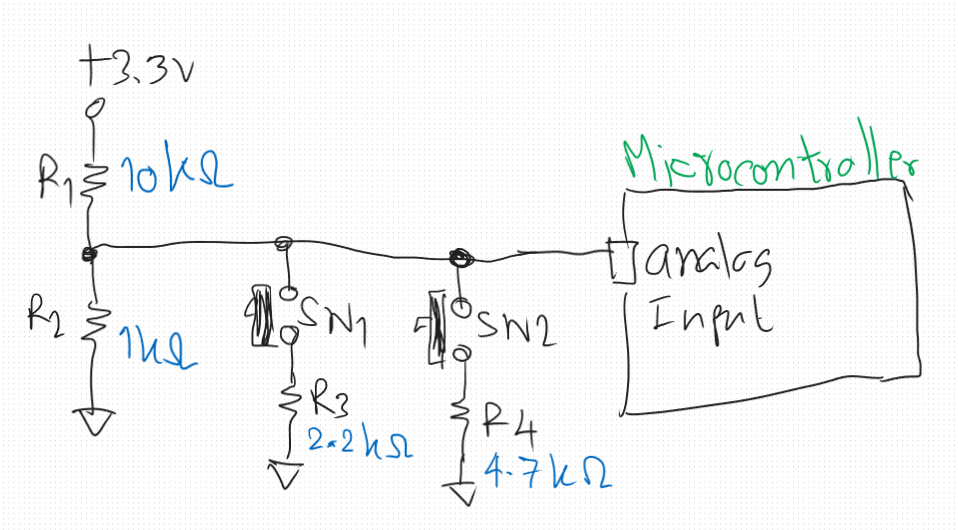

### การคำนวณแรงดัน:

**ไม่กดปุ่มใดๆ:**
- แรงดัน = 3.3V × (1kΩ)/(10kΩ + 1kΩ) = **0.3V**

**กด Button 1:**  
- แรงดัน = 3.3V × (2.2kΩ||1kΩ)/(10kΩ + (2.2kΩ||1kΩ)) = **≈0.9V**

**กด Button 2:**
- แรงดัน = 3.3V × (4.7kΩ||1kΩ)/(10kΩ + (4.7kΩ||1kΩ)) = **≈1.2V**

**กด Button 1+2:**
- แรงดัน = 3.3V × (2.2kΩ||4.7kΩ||1kΩ)/(10kΩ + (2.2kΩ||4.7kΩ||1kΩ)) = **≈1.6V**

### อุปกรณ์ที่ใช้:
- ตัวต้านทาน: 10kΩ, 4.7kΩ, 2.2kΩ, 1kΩ  
- Push buttons 2 ตัว
- สายจัมเปอร์

### ตัวอย่างการทดลอง: 2 Buttons บน ADC Pin เดียว (ESP-IDF)

In [ ]:
// main.c - ตัวอย่างการทดลอง: 2 Buttons บน ADC Pin เดียว
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/gpio.h"
#include "driver/adc.h"
#include "esp_adc_cal.h"
#include "esp_log.h"
#include "esp_timer.h"

// กำหนด pins
#define ADC_BUTTONS_PIN   ADC1_CHANNEL_4    // GPIO32 สำหรับ ADC
#define LED1_PIN          GPIO_NUM_23       // LED 1
#define LED2_PIN          GPIO_NUM_22       // LED 2

// ADC parameters
#define DEFAULT_VREF      1100              // Default reference voltage
#define ADC_SAMPLES       64                // จำนวน samples สำหรับเฉลี่ย

static const char *TAG = "VOLTAGE_DIVIDER";

// ตัวแปรสำหรับ ADC calibration
static esp_adc_cal_characteristics_t *adc_chars;

// Button states
typedef enum {
    BUTTON_NONE = 0,
    BUTTON_1,
    BUTTON_2,
    BUTTON_BOTH
} button_state_t;

// ฟังก์ชันเริ่มต้น ADC
void init_adc(void)
{
    // กำหนดค่า ADC1
    adc1_config_width(ADC_WIDTH_BIT_12);  // 12-bit resolution (0-4095)
    adc1_config_channel_atten(ADC_BUTTONS_PIN, ADC_ATTEN_DB_11);  // 0-3.3V range
    
    // Calibrate ADC
    adc_chars = calloc(1, sizeof(esp_adc_cal_characteristics_t));
    esp_adc_cal_characterize(ADC_UNIT_1, ADC_ATTEN_DB_11, ADC_WIDTH_BIT_12, 
                           DEFAULT_VREF, adc_chars);
    
    ESP_LOGI(TAG, "ADC Calibrated");
}

// ฟังก์ชันอ่านค่าแรงดันจาก ADC
uint32_t read_voltage_mv(void)
{
    uint32_t adc_reading = 0;
    
    // เฉลี่ยค่าจากหลาย samples
    for (int i = 0; i < ADC_SAMPLES; i++) {
        adc_reading += adc1_get_raw(ADC_BUTTONS_PIN);
    }
    adc_reading /= ADC_SAMPLES;
    
    // แปลงเป็นแรงดัน (millivolts)
    uint32_t voltage = esp_adc_cal_raw_to_voltage(adc_reading, adc_chars);
    
    return voltage;
}

// ฟังก์ชันแปลงแรงดันเป็นสถานะ button
button_state_t voltage_to_button_state(uint32_t voltage_mv)
{
    // กำหนด threshold values (ปรับตามค่าจริงจากการทดลอง)
    if (voltage_mv < 500) {          // < 0.5V = ไม่กดปุ่มใดๆ
        return BUTTON_NONE;
    } else if (voltage_mv < 1000) {  // 0.5-1.0V = กด Button 1
        return BUTTON_1;
    } else if (voltage_mv < 1400) {  // 1.0-1.4V = กด Button 2
        return BUTTON_2;
    } else {                         // > 1.4V = กดทั้งสอง buttons
        return BUTTON_BOTH;
    }
}

// ฟังก์ชันควบคุม LEDs ตามสถานะ button
void control_leds(button_state_t button_state)
{
    switch (button_state) {
        case BUTTON_NONE:
            gpio_set_level(LED1_PIN, 0);
            gpio_set_level(LED2_PIN, 0);
            break;
            
        case BUTTON_1:
            gpio_set_level(LED1_PIN, 1);
            gpio_set_level(LED2_PIN, 0);
            break;
            
        case BUTTON_2:
            gpio_set_level(LED1_PIN, 0);
            gpio_set_level(LED2_PIN, 1);
            break;
            
        case BUTTON_BOTH:
            gpio_set_level(LED1_PIN, 1);
            gpio_set_level(LED2_PIN, 1);
            break;
    }
}

// Task สำหรับอ่าน buttons และควบคุม LEDs
void button_reader_task(void *pvParameters)
{
    button_state_t current_state = BUTTON_NONE;
    button_state_t last_state = BUTTON_NONE;
    
    ESP_LOGI(TAG, "=== Voltage Divider Button Reader ===");
    ESP_LOGI(TAG, "Button monitoring started...");
    
    while(1) {
        // อ่านค่าแรงดัน
        uint32_t voltage = read_voltage_mv();
        
        // แปลงเป็นสถานะ button
        current_state = voltage_to_button_state(voltage);
        
        // แสดงผลเมื่อสถานะเปลี่ยน
        if (current_state != last_state) {
            ESP_LOGI(TAG, "Voltage: %dmV", voltage);
            
            switch (current_state) {
                case BUTTON_NONE:
                    ESP_LOGI(TAG, "Button State: NONE");
                    break;
                case BUTTON_1:
                    ESP_LOGI(TAG, "Button State: BUTTON 1 PRESSED");
                    break;
                case BUTTON_2:
                    ESP_LOGI(TAG, "Button State: BUTTON 2 PRESSED");
                    break;
                case BUTTON_BOTH:
                    ESP_LOGI(TAG, "Button State: BOTH BUTTONS PRESSED");
                    break;
            }
            
            // ควบคุม LEDs
            control_leds(current_state);
            last_state = current_state;
        }
        
        // อ่านทุก 50ms
        vTaskDelay(pdMS_TO_TICKS(50));
    }
}

void app_main(void)
{
    // เริ่มต้น ADC
    init_adc();
    
    // กำหนดค่า GPIO สำหรับ LEDs
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED1_PIN) | (1ULL << LED2_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    // ปิด LEDs เริ่มต้น
    gpio_set_level(LED1_PIN, 0);
    gpio_set_level(LED2_PIN, 0);
    
    ESP_LOGI(TAG, "GPIO Configuration Complete");
    ESP_LOGI(TAG, "ADC Pin: GPIO32, LED1: GPIO%d, LED2: GPIO%d", LED1_PIN, LED2_PIN);
    
    // สร้าง task สำหรับอ่าน buttons
    xTaskCreate(button_reader_task, "button_reader_task", 4096, NULL, 10, NULL);
}

### ขั้นตอนการทดลอง:

#### 1. การต่อวงจร:
```
ESP32 GPIO32 (ADC1_CH4) ←── Voltage Divider Network
ESP32 GPIO23 (LED1)     ←── LED + Resistor → GND  
ESP32 GPIO22 (LED2)     ←── LED + Resistor → GND
ESP32 3V3               ←── Supply voltage
ESP32 GND               ←── Ground
```

#### 2. การทดสอบ:
1. **ไม่กดปุ่ม**: LEDs ทั้งหมดดับ (แรงดัน ~0.3V)
2. **กด Button 1**: LED1 ติด (แรงดัน ~0.9V)  
3. **กด Button 2**: LED2 ติด (แรงดัน ~1.2V)
4. **กดทั้งสอง**: LEDs ทั้งสองติด (แรงดัน ~1.6V)

#### 3. การปรับแต่ง Threshold:
หากค่าแรงดันไม่ตรงตามที่คำนวณ ให้ปรับค่า threshold ในฟังก์ชัน `voltage_to_button_state()`

#### 4. คุณสมบัติเด่น:
- **ADC Calibration**: ใช้ค่า calibration สำหรับความแม่นยำ
- **Sample Averaging**: เฉลี่ยค่าจาก 64 samples ลด noise
- **Real-time Monitoring**: แสดงค่าแรงดันและสถานะแบบ real-time
- **GPIO Control**: ควบคุม LEDs ตามสถานะ buttons

### ตัวอย่างขั้นสูง: 4 Buttons บน ADC Pin เดียว

In [ ]:
// main.c - ตัวอย่างขั้นสูง: 4 Buttons บน ADC Pin เดียว
#include <stdio.h>
#include "freertos/FreeRTOS.h"
#include "freertos/task.h"
#include "driver/gpio.h"
#include "driver/adc.h"
#include "esp_adc_cal.h"
#include "esp_log.h"

// กำหนด pins
#define ADC_BUTTONS_PIN   ADC1_CHANNEL_4    // GPIO32
#define LED1_PIN          GPIO_NUM_19       // LED1 - UP
#define LED2_PIN          GPIO_NUM_21       // LED2 - DOWN  
#define LED3_PIN          GPIO_NUM_22       // LED3 - LEFT
#define LED4_PIN          GPIO_NUM_23       // LED4 - RIGHT

#define ADC_SAMPLES       32

static const char *TAG = "4BUTTON_ADC";
static esp_adc_cal_characteristics_t *adc_chars;

// Button definitions
typedef enum {
    BTN_NONE = 0,
    BTN_UP,
    BTN_DOWN, 
    BTN_LEFT,
    BTN_RIGHT
} button_id_t;

// Voltage thresholds (ปรับตามค่าจริง)
typedef struct {
    button_id_t id;
    uint32_t min_voltage;
    uint32_t max_voltage;
    const char* name;
    gpio_num_t led_pin;
} button_threshold_t;

static const button_threshold_t button_thresholds[] = {
    {BTN_NONE,  0,    400,  "NONE",  GPIO_NUM_NC},
    {BTN_UP,    400,  800,  "UP",    LED1_PIN},
    {BTN_DOWN,  800,  1200, "DOWN",  LED2_PIN},
    {BTN_LEFT,  1200, 1600, "LEFT",  LED3_PIN},
    {BTN_RIGHT, 1600, 3300, "RIGHT", LED4_PIN}
};

#define NUM_BUTTONS (sizeof(button_thresholds) / sizeof(button_threshold_t))

void init_adc(void)
{
    adc1_config_width(ADC_WIDTH_BIT_12);
    adc1_config_channel_atten(ADC_BUTTONS_PIN, ADC_ATTEN_DB_11);
    
    adc_chars = calloc(1, sizeof(esp_adc_cal_characteristics_t));
    esp_adc_cal_characterize(ADC_UNIT_1, ADC_ATTEN_DB_11, ADC_WIDTH_BIT_12, 
                           1100, adc_chars);
    
    ESP_LOGI(TAG, "ADC initialized and calibrated");
}

uint32_t read_voltage_mv(void)
{
    uint32_t adc_reading = 0;
    
    for (int i = 0; i < ADC_SAMPLES; i++) {
        adc_reading += adc1_get_raw(ADC_BUTTONS_PIN);
    }
    adc_reading /= ADC_SAMPLES;
    
    return esp_adc_cal_raw_to_voltage(adc_reading, adc_chars);
}

button_id_t get_pressed_button(uint32_t voltage_mv)
{
    for (int i = 0; i < NUM_BUTTONS; i++) {
        if (voltage_mv >= button_thresholds[i].min_voltage && 
            voltage_mv < button_thresholds[i].max_voltage) {
            return button_thresholds[i].id;
        }
    }
    return BTN_NONE;
}

void control_leds(button_id_t pressed_button)
{
    // ปิด LEDs ทั้งหมด
    gpio_set_level(LED1_PIN, 0);
    gpio_set_level(LED2_PIN, 0);
    gpio_set_level(LED3_PIN, 0);
    gpio_set_level(LED4_PIN, 0);
    
    // เปิด LED ที่ตรงกับ button ที่กด
    for (int i = 0; i < NUM_BUTTONS; i++) {
        if (button_thresholds[i].id == pressed_button && 
            button_thresholds[i].led_pin != GPIO_NUM_NC) {
            gpio_set_level(button_thresholds[i].led_pin, 1);
            break;
        }
    }
}

void button_monitor_task(void *pvParameters)
{
    button_id_t current_button = BTN_NONE;
    button_id_t last_button = BTN_NONE;
    
    ESP_LOGI(TAG, "=== 4-Button ADC Monitor ===");
    ESP_LOGI(TAG, "UP: LED1, DOWN: LED2, LEFT: LED3, RIGHT: LED4");
    
    while(1) {
        uint32_t voltage = read_voltage_mv();
        current_button = get_pressed_button(voltage);
        
        if (current_button != last_button) {
            ESP_LOGI(TAG, "Voltage: %dmV", voltage);
            
            // หา button name
            const char* button_name = "UNKNOWN";
            for (int i = 0; i < NUM_BUTTONS; i++) {
                if (button_thresholds[i].id == current_button) {
                    button_name = button_thresholds[i].name;
                    break;
                }
            }
            
            ESP_LOGI(TAG, "Button: %s", button_name);
            control_leds(current_button);
            last_button = current_button;
        }
        
        vTaskDelay(pdMS_TO_TICKS(50));
    }
}

void app_main(void)
{
    // เริ่มต้น ADC
    init_adc();
    
    // กำหนดค่า GPIO สำหรับ LEDs
    gpio_config_t led_config = {
        .pin_bit_mask = (1ULL << LED1_PIN) | (1ULL << LED2_PIN) |
                        (1ULL << LED3_PIN) | (1ULL << LED4_PIN),
        .mode = GPIO_MODE_OUTPUT,
        .pull_up_en = GPIO_PULLUP_DISABLE,
        .pull_down_en = GPIO_PULLDOWN_DISABLE,
        .intr_type = GPIO_INTR_DISABLE
    };
    gpio_config(&led_config);
    
    // ปิด LEDs เริ่มต้น
    control_leds(BTN_NONE);
    
    ESP_LOGI(TAG, "System initialized");
    ESP_LOGI(TAG, "ADC: GPIO32, LEDs: GPIO19-23");
    
    // แสดง voltage thresholds
    ESP_LOGI(TAG, "Voltage Thresholds:");
    for (int i = 0; i < NUM_BUTTONS; i++) {
        ESP_LOGI(TAG, "%s: %d-%dmV", 
                button_thresholds[i].name,
                button_thresholds[i].min_voltage,
                button_thresholds[i].max_voltage);
    }
    
    xTaskCreate(button_monitor_task, "button_monitor", 4096, NULL, 10, NULL);
}

### สรุปเทคนิค Voltage Divider

#### ข้อดี:
1. **ประหยัด GPIO pins** - ใช้ pin เดียวสำหรับหลาย buttons
2. **ลดความซับซ้อน** - coding ง่ายขึ้นเมื่อมี buttons เยอะ  
3. **ความน่าเชื่อถือ** - ไม่มีปัญหา debouncing เหมือน digital input
4. **Scalable** - เพิ่ม buttons ได้ง่าย (จำกัดด้วยความแม่นยำ ADC)

#### ข้อเสีย:
1. **ต้องใช้ ADC** - ใช้ขา analog input เท่านั้น
2. **อ่านครั้งละ 1 button** - ไม่สามารถกดพร้อมกันได้
3. **ความแม่นยำ** - ขึ้นอยู่กับค่าตัวต้านทานและ noise
4. **Power consumption** - มีกระแสไหลตลอดเวลา

#### การประยุกต์ใช้:
- **Remote Control** - ควบคุมระยะไกล
- **Menu Navigation** - UP/DOWN/LEFT/RIGHT
- **Game Controllers** - joystick replacement  
- **Industrial Controls** - HMI panels

#### เทคนิคขั้นสูง:
- ใช้ **Hysteresis** ป้องกัน noise
- **Multiple ADC channels** สำหรับ buttons matrix
- **Exponential smoothing** สำหรับ signal filtering